# Frame the problem and look at the big picture 

Chewy wants to develop a dog door that only opens for your pet. They would like an initial system that can recognize the breed of the dog. The door should not open if the dog is not the same breed as your dog. They have provided us with over 20,000 images of 120 different breeds of dogs. They want a high precision so that no other dogs (or mistaken creatures) are able to enter the door. Their current products require the pet to have chip or a special collar. They would like to have a new system that requires no external devices, this is a proof of concept problem because if they can't predict breed, they may not even be able to detect one dog properly.

This will be a supervised offline classification problem. We will use precision because we want to lower the amount of False Positives and keep True Positives up. (It would be acceptable for the door not to open every single time, but it is not acceptable to open for the incorrect breed.)

Since our system is sort of a starting point for their ultimate goal, we will shoot for 85% precision as well as a high accuracy (85%). Since this is more of a proof of concept though, we have some leeway with precision.

The MNIST problems are similar and we can reuse some code from notebooks.

There are no experts available to us.

The manual solution is the use of a chip/collar system.
Look for body shape, face shape, color

We assume the data is labelled correctly and not missing significant portions.
We will resize the images to be the same size, but this could introduce other issues potentially. 



In [ ]:
!curl vision.stanford.edu/aditya86/ImageNetDogs/images.tar --output images

In [ ]:
!tar -xf images

In [ ]:
!hostname

In [1]:
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc

from tensorflow import keras

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn import set_config
set_config(display='diagram')

from matplotlib import style
style.use('dark_background')

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
def load_images_and_labels(categories, fpath):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_array = Image.fromarray(img, 'RGB')
            resized_img = img_array.resize((227, 227))
            img_lst.append(np.array(resized_img))
            labels.append(index)

    images = np.array(img_lst).astype(np.float32)/255
    labels = np.array(labels).astype(np.int32)
    
    return images, labels

def display_rand_images(images, labels, names):
    plt.figure(1 , figsize = (19 , 10))
    for i in range(9):
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , i+1)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Dog breed : {} ({})'.format(labels[r[0]], names[labels[r[0]]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()

def display_images(data, gray=False):
    plt.figure(1 , figsize = (19 , 10))
    for i in range(9):
        r = np.random.randint(0 , data.shape[0] , 1)
        plt.subplot(3 , 3 , i+1)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        if gray:
            plt.imshow(data[r[0]], cmap='gray')
        else:
            plt.imshow(data[r[0]])
    plt.show()

In [4]:
# def load_images_and_labels(categories, fpath):
#     num_imgs = 0
#     for _, _, files in os.walk(fpath):
#         num_imgs += len(files)

#     imgs = np.empty((num_imgs, 3, 227, 227), dtype=np.float32)
#     labels = []
#     for index, category in enumerate(categories):
#         for image_name in os.listdir(fpath+"/"+category):
#             labels.append(index)
#             img = cv2.imread(fpath+"/"+category+"/"+image_name)
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             img_array = Image.fromarray(img, 'RGB').resize((227, 227))
#             np.append(imgs, img_array)
#             gc.collect()


#     # images = np.array(img_lst).astype(np.float32)/255
#     labels = np.array(labels).astype(np.int32)
    
#     return imgs, labels

# Get the data 


In [5]:
# fpath = os.getcwd() + "/archive/images/Images"
# fpath = os.getcwd() + "/Images"
fpath = os.getcwd() + "/images"
categories = os.listdir(fpath)
names = [cat.split('-')[-1] for cat in categories]

In [6]:
# This will take 2-3 minutes to run
images, labels = load_images_and_labels(categories[:20], fpath) # Don't try to do all of them

In [7]:
len(images), len(labels), len(names)

(3633, 3633, 120)

In [8]:
type(images), type(labels), type(names)

(numpy.ndarray, numpy.ndarray, list)

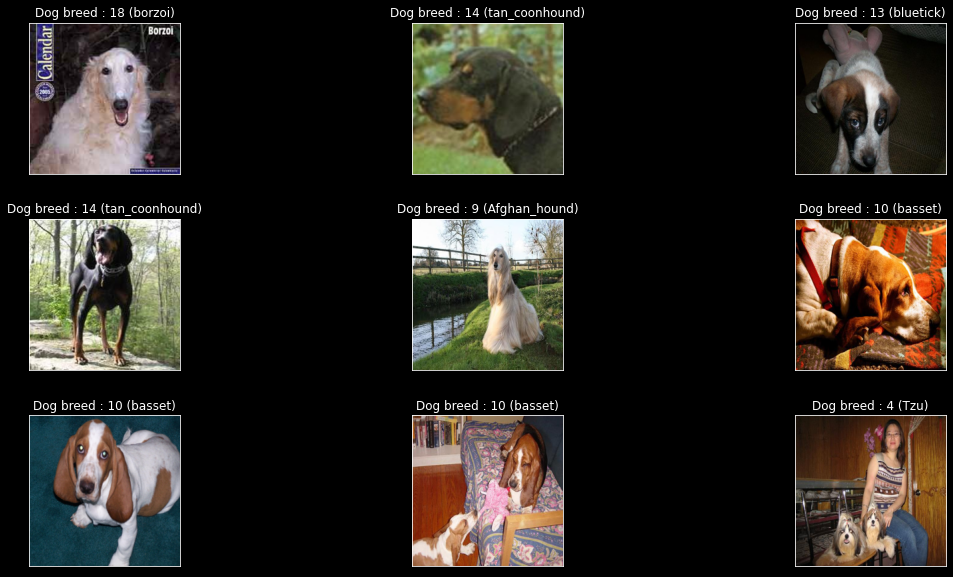

In [9]:
display_rand_images(images, labels, names)

In [10]:
# Shuffle the data
n = np.arange(images.shape[0])
np.random.seed(42)
np.random.shuffle(n)
images = images[n]
labels = labels[n]

In [11]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(images, labels, test_size=0.2, random_state=42) # THIS IS THE DATA TO PROCESS

In [12]:
X_val, X_test_, y_val, y_test_ = train_test_split(X_test_, y_test_, test_size=0.2, random_state=42)

### Data for Explore

In [13]:
df = pd.DataFrame(X_train_.reshape(X_train_.shape[0], -1))
df["labels"] = y_train_
df


,0,1,2,3,4,5,6,7,8,9,...,154578,154579,154580,154581,154582,154583,154584,154585,154586,labels
0,0.078431,0.043137,0.007843,0.109804,0.047059,0.003922,0.223529,0.109804,0.058824,0.415686,...,0.474510,0.333333,0.262745,0.325490,0.156863,0.023529,0.345098,0.168627,0.023529,11
1,0.235294,0.200000,0.176471,0.278431,0.250980,0.227451,0.384314,0.364706,0.341176,0.219608,...,0.474510,0.466667,0.454902,0.447059,0.454902,0.427451,0.411765,0.419608,0.392157,5
2,0.572549,0.529412,0.513726,0.482353,0.439216,0.423529,0.490196,0.447059,0.431373,0.466667,...,0.552941,0.450980,0.400000,0.513726,0.431373,0.372549,0.513726,0.439216,0.380392,0
3,0.537255,0.494118,0.462745,0.654902,0.611765,0.596078,0.615686,0.568627,0.568627,0.686275,...,0.800000,0.749020,0.682353,0.800000,0.749020,0.682353,0.803922,0.752941,0.686275,0
4,0.474510,0.560784,0.305882,0.470588,0.556863,0.301961,0.474510,0.560784,0.305882,0.478431,...,0.247059,0.345098,0.113725,0.400000,0.470588,0.250980,0.450980,0.521569,0.301961,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2901,0.129412,0.133333,0.168627,0.113725,0.117647,0.156863,0.125490,0.129412,0.168627,0.121569,...,0.411765,0.349020,0.239216,0.423529,0.345098,0.235294,0.415686,0.325490,0.223529,18
2902,0.772549,0.513726,0.411765,0.764706,0.505882,0.415686,0.725490,0.462745,0.388235,0.729412,...,0.392157,0.392157,0.415686,0.400000,0.392157,0.431373,0.474510,0.466667,0.509804,2
2903,0.203922,0.031373,0.137255,0.274510,0.101961,0.207843,0.325490,0.152941,0.258824,0.337255,...,0.254902,0.078431,0.200000,0.219608,0.043137,0.164706,0.239216,0.070588,0.188235,18
2904,0.580392,0.439216,0.313726,0.576471,0.435294,0.309804,0.572549,0.427451,0.317647,0.603922,...,0.564706,0.454902,0.278431,0.584314,0.482353,0.301961,0.568627,0.478431,0.294118,17


In [14]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
# val_set, test_set = train_test_split(test_set, test_size=0.5, random_state=42)

In [15]:
X_train, y_train = train_set.drop('labels', axis=1), train_set['labels']

In [16]:
train_subset = train_set.sample(n=1000, random_state=42)
X_train_subset, y_train_subset = train_subset.drop('labels', axis=1), train_subset['labels']

# Explore the data


There wasn't much exploration to do because the ranges for values are all 0-255.
There are no missing values because they are images and we have reshaped all of them to make processing easier. 

We did look into the correlations between the color channels and the target. We also looked at the grayscaled versions of the images.

We performed PCA on both grayscaled and colored images and unsurprisingly, many of the values are not necessary to replicate the images. 

However, many images cannot be as accurately recovered because some images:
  * are not of just one dog
  * may not have the dog as the focus of the picture
  * may have many humans in the image
  * have odd angles

These reasons will likely affect our model when we get there.

### Need to use the dataframe for some of these

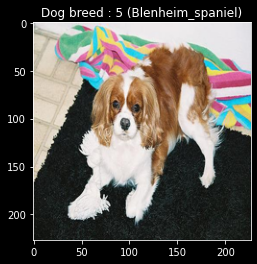

In [17]:
# plot the first row of the train set as an image
plt.imshow(X_train.iloc[0, :].values.reshape(227, 227, 3));
plt.title('Dog breed : {} ({})'.format(y_train.iloc[0], names[y_train.iloc[0]]));

In [18]:
# This is about expected
# X_train_.describe()

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 163 to 860
Columns: 154587 entries, 0 to 154586
dtypes: float32(154587)
memory usage: 1.3 GB


In [20]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,154577,154578,154579,154580,154581,154582,154583,154584,154585,154586
163,0.729412,0.745098,0.749020,0.745098,0.749020,0.756863,0.843137,0.847059,0.854902,0.870588,...,0.062745,0.078431,0.086275,0.074510,0.062745,0.070588,0.058824,0.062745,0.070588,0.058824
1947,0.654902,0.572549,0.505882,0.662745,0.580392,0.513726,0.662745,0.580392,0.513726,0.650980,...,0.498039,0.611765,0.537255,0.482353,0.603922,0.529412,0.474510,0.596078,0.521569,0.462745
252,0.600000,0.525490,0.396078,0.584314,0.521569,0.388235,0.580392,0.537255,0.400000,0.580392,...,0.188235,0.309804,0.313726,0.180392,0.337255,0.325490,0.184314,0.337255,0.321569,0.176471
1831,0.282353,0.305882,0.270588,0.278431,0.301961,0.262745,0.286275,0.309804,0.274510,0.305882,...,0.325490,0.392157,0.403922,0.329412,0.396078,0.407843,0.333333,0.396078,0.407843,0.333333
2043,0.811765,0.823529,0.882353,0.811765,0.823529,0.882353,0.811765,0.823529,0.882353,0.811765,...,0.411765,0.521569,0.443137,0.243137,0.603922,0.541176,0.349020,0.541176,0.486275,0.301961


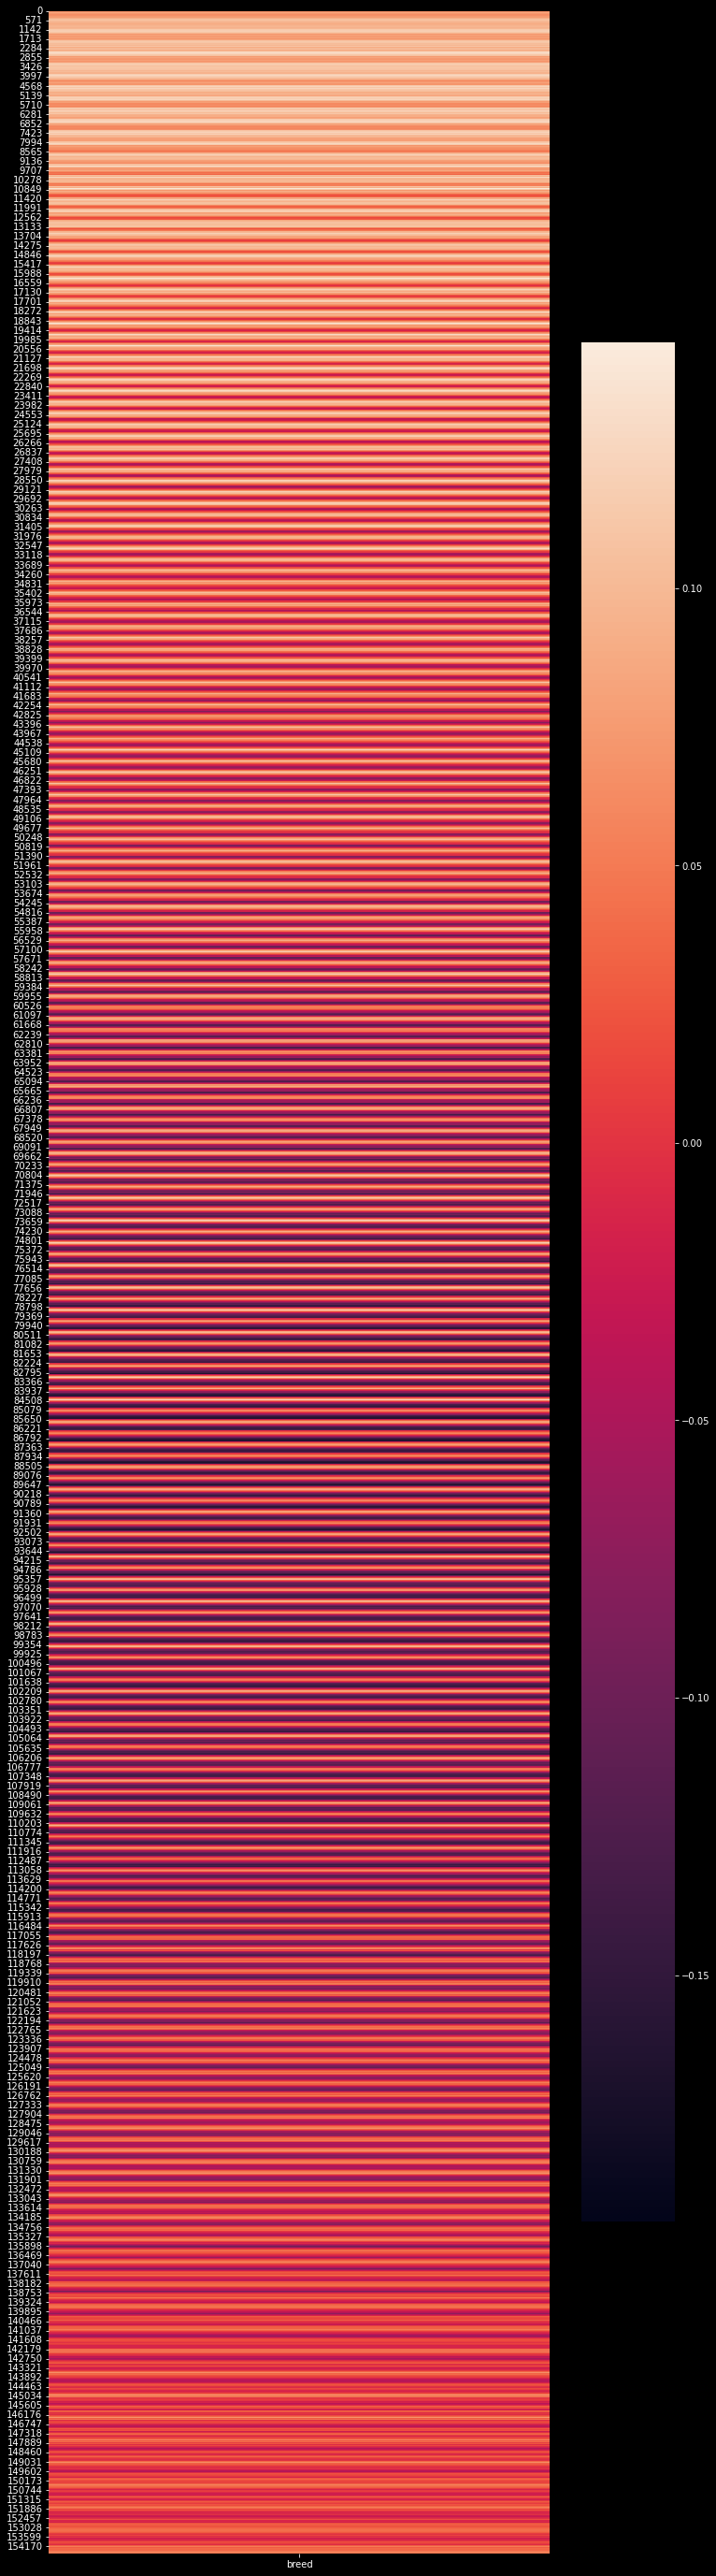

In [21]:
# Look for the useless features
c = pd.DataFrame({'breed': X_train.corrwith(y_train)})
plt.figure(figsize=(12,50))
sns.heatmap(c);

### Look at each color channel

In [22]:
# get each color channel
r = X_train[X_train.columns[0::3]]
g = X_train[X_train.columns[1::3]]
b = X_train[X_train.columns[2::3]]

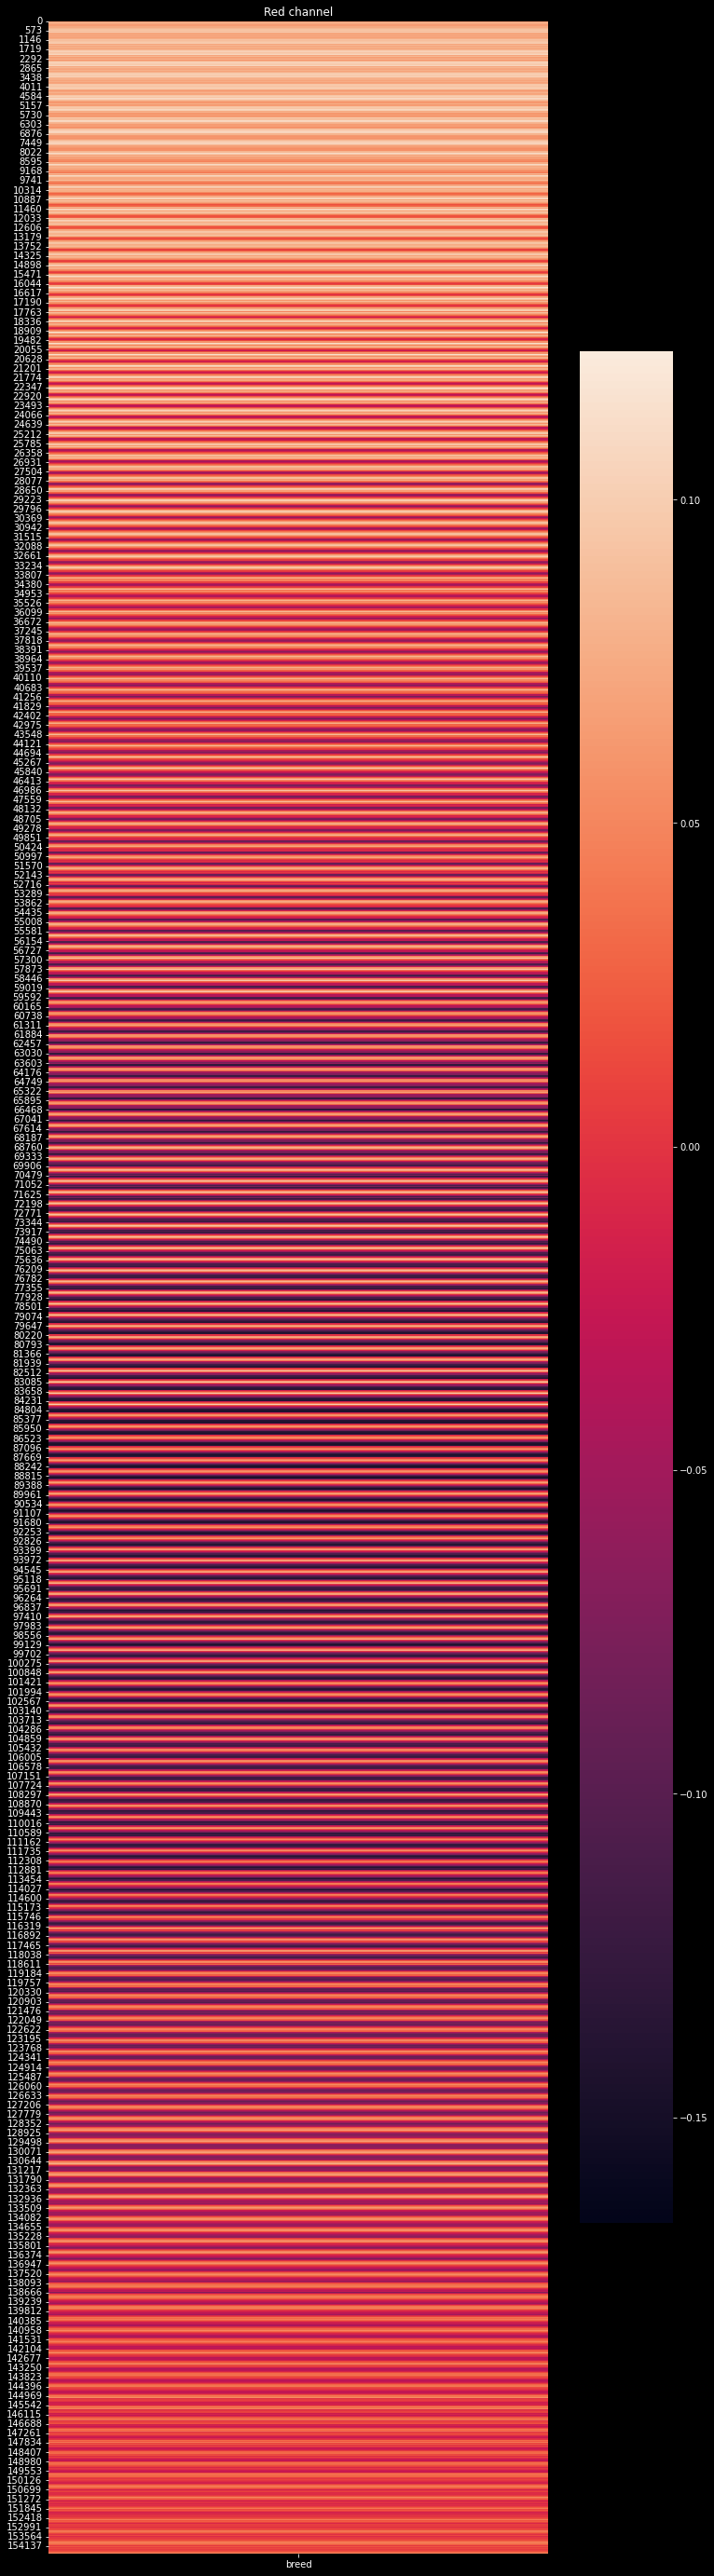

In [23]:
c = pd.DataFrame({'breed': r.corrwith(y_train)})
plt.figure(figsize=(12,50))
plt.title('Red channel')
sns.heatmap(c);

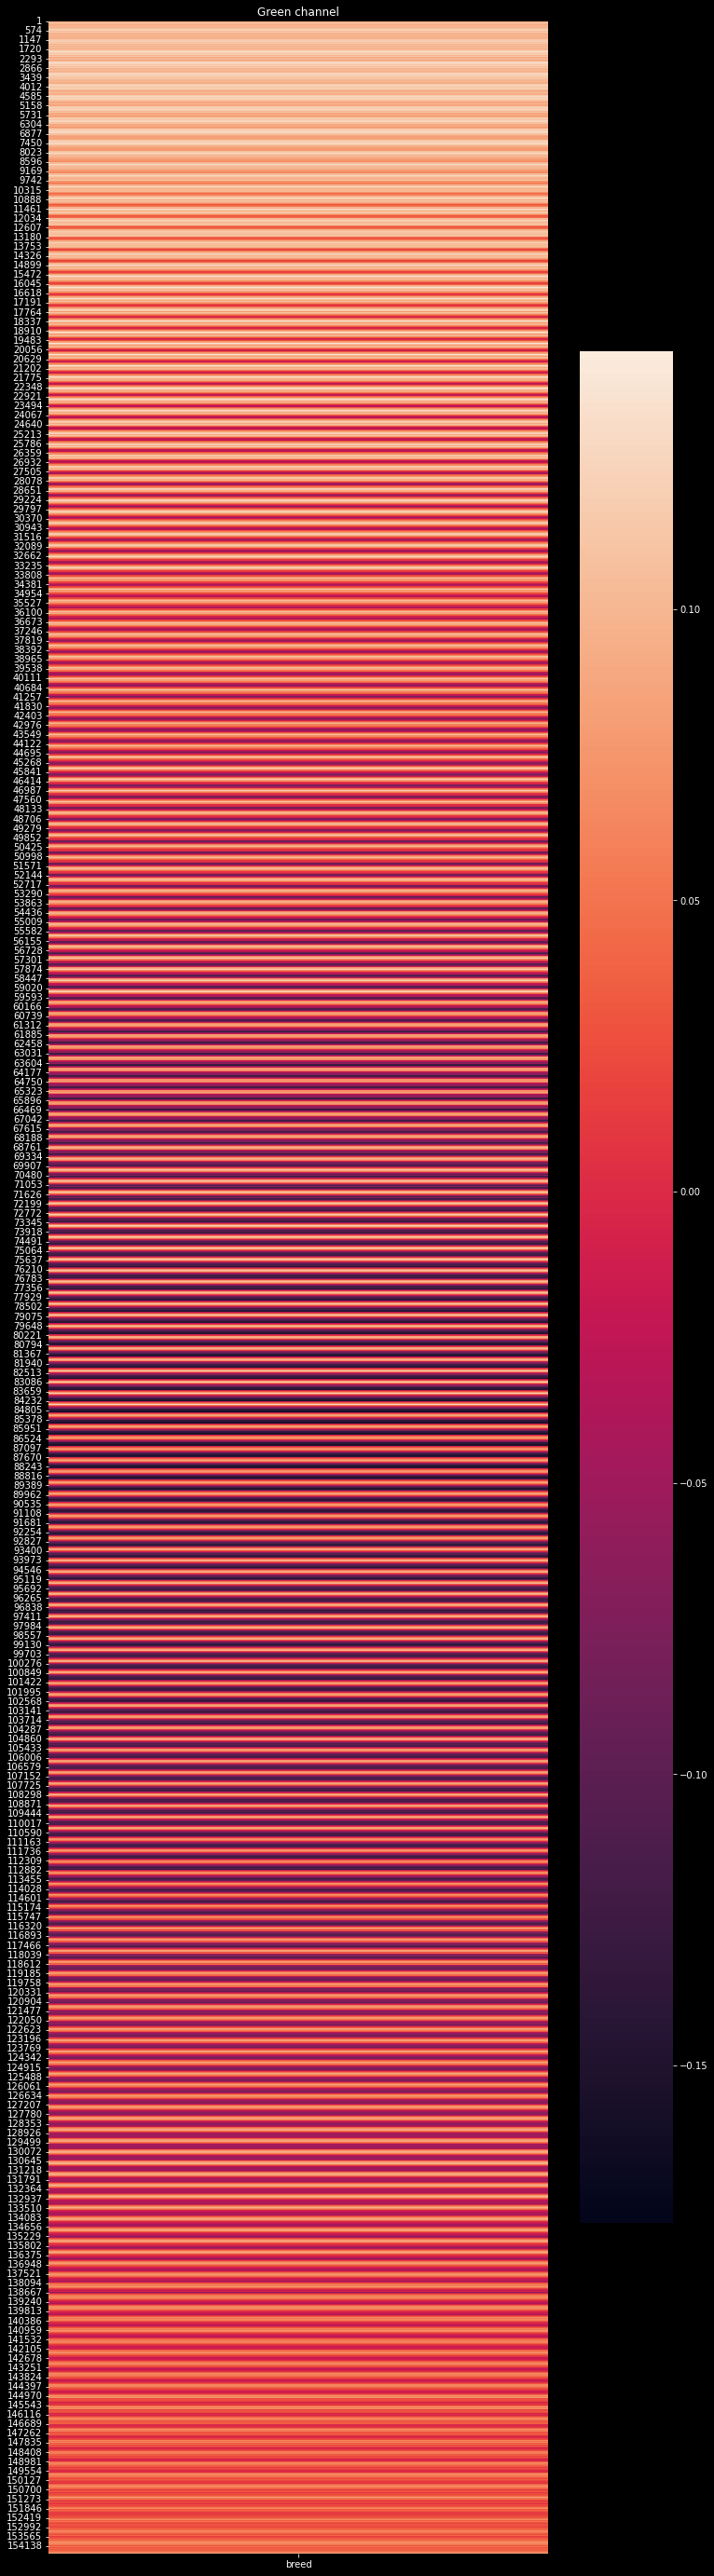

In [24]:
c = pd.DataFrame({'breed': g.corrwith(y_train)})
plt.figure(figsize=(12,50))
plt.title('Green channel')
sns.heatmap(c);

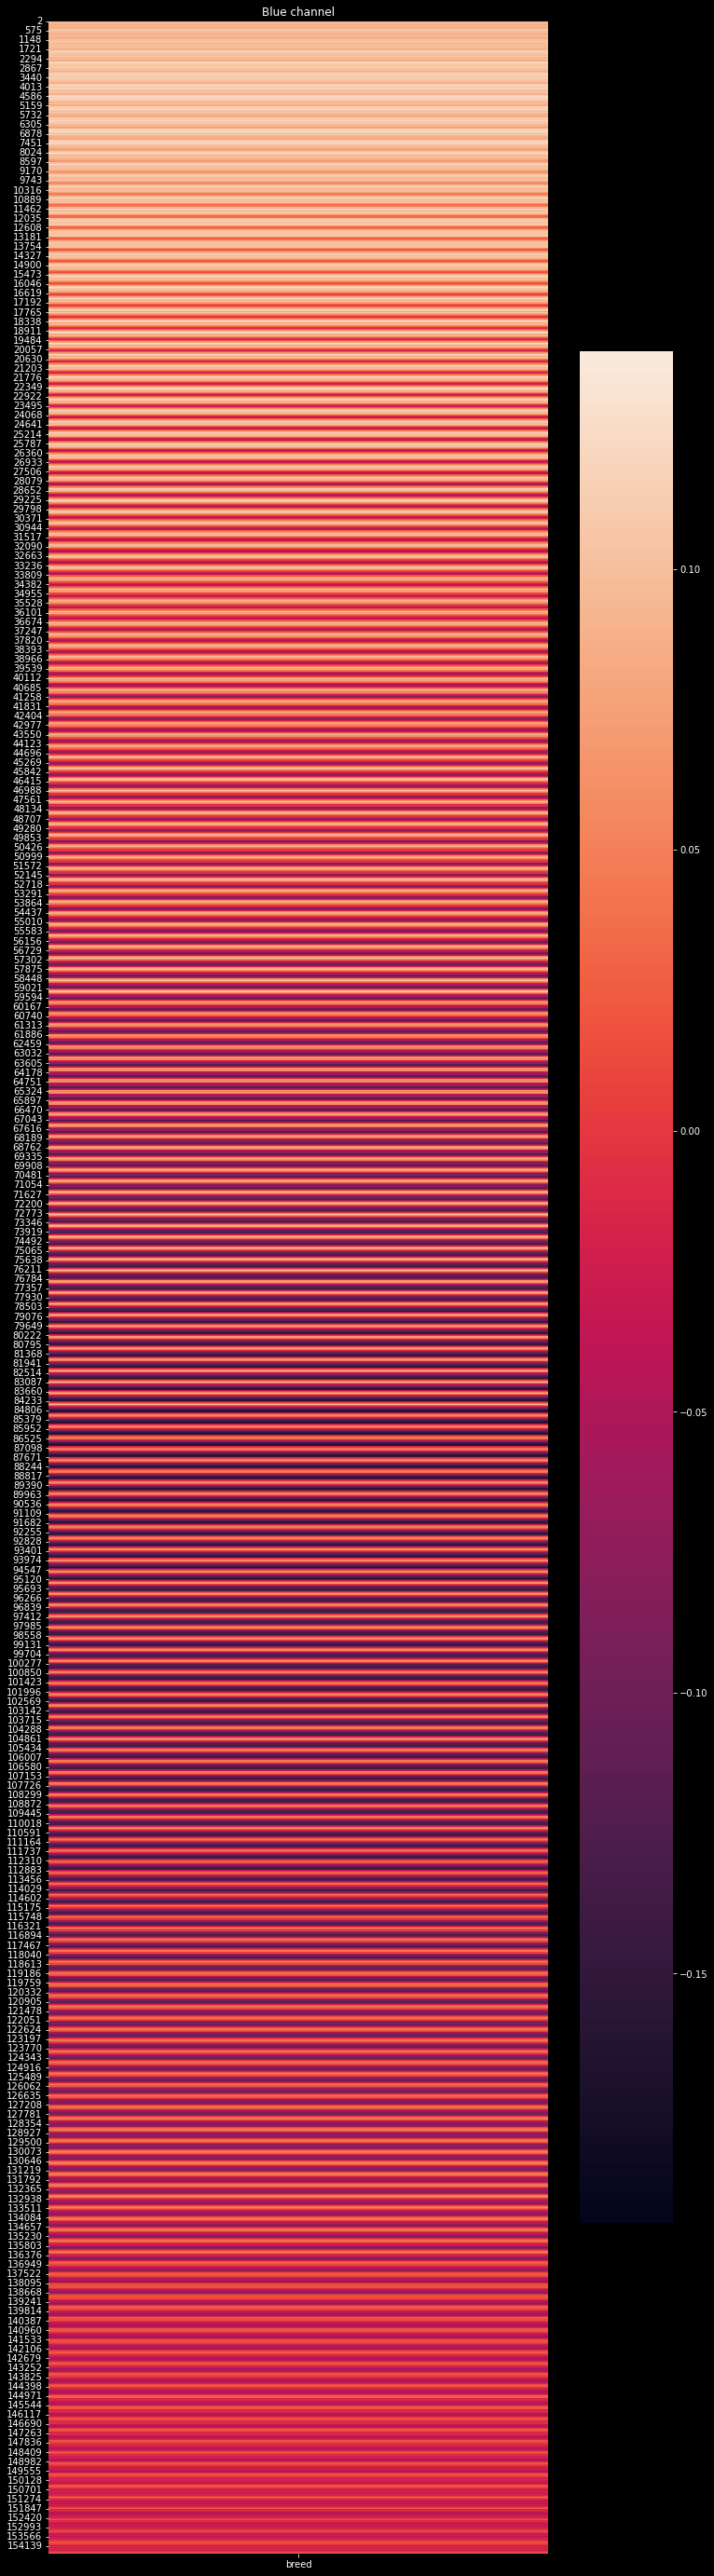

In [25]:
c = pd.DataFrame({'breed': b.corrwith(y_train)})
plt.figure(figsize=(12,50))
plt.title('Blue channel')
sns.heatmap(c);

## PCA

Text(0, 0.5, 'Cumulative explained variance')

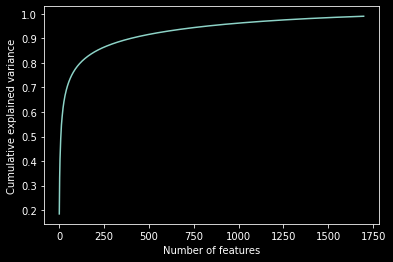

In [26]:
pca = PCA(n_components=0.99)
pca.fit(X_train, y_train)

plt.figure()
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of features')
plt.ylabel('Cumulative explained variance')

In [27]:
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


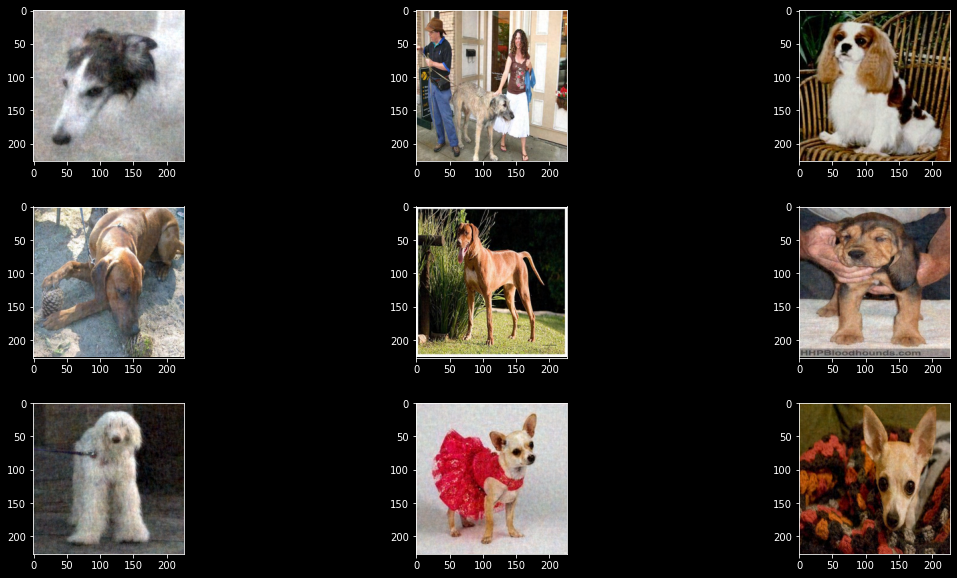

In [28]:
# Let's see how good the recovery is
display_images(X_recovered.reshape(X_train.shape[0], 227, 227, 3));

In [29]:
# Find importances of each feature
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
sorted(zip(rf.feature_importances_, X_train.columns), reverse=True)

[(0.00016244733467367492, 77354),
 (0.00013497636687921966, 95079),
 (0.00013487473847623608, 92993),
 (0.00013464054458632894, 61010),
 (0.0001287651703132787, 47974),
 (0.00012797436042153354, 85407),
 (0.000124978656972503, 53309),
 (0.00012056482370414177, 64412),
 (0.00012032835034875113, 94289),
 (0.00011925811154104721, 62282),
 (0.00011711885489578094, 43884),
 (0.00011357066186800729, 81434),
 (0.0001128568890534224, 145204),
 (0.00011218293118508502, 18472),
 (0.00011198831714822274, 90128),
 (0.00011119909491247381, 92255),
 (0.00011011813652781102, 86078),
 (0.00010960701701283555, 85439),
 (0.00010878031961226763, 80042),
 (0.0001073714281392229, 81395),
 (0.00010406175398204232, 77967),
 (0.00010390589026756941, 73257),
 (0.00010358604386669063, 50473),
 (0.00010344281381908434, 86138),
 (0.00010266140074003013, 91520),
 (0.00010262893300537491, 69812),
 (0.00010235062345492697, 50817),
 (0.00010200396481087314, 73305),
 (0.0001010395582165806, 89444),
 (0.000101036305945

## Try Grayscale

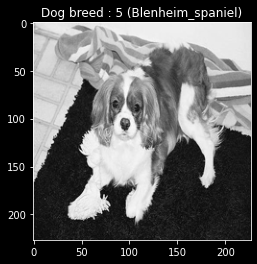

In [30]:
# plot the first image
plt.imshow(cv2.cvtColor(X_train.iloc[0,:].values.reshape(227, 227, 3)*255, cv2.COLOR_RGB2GRAY), cmap='gray');
plt.title('Dog breed : {} ({})'.format(y_train.iloc[0], names[y_train.iloc[0]]));

In [31]:
ims = X_train.iloc[:,:].values.reshape(X_train.shape[0], 227, 227, 3)*255

In [32]:
X_subset_gray = np.array([cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) for im in ims])

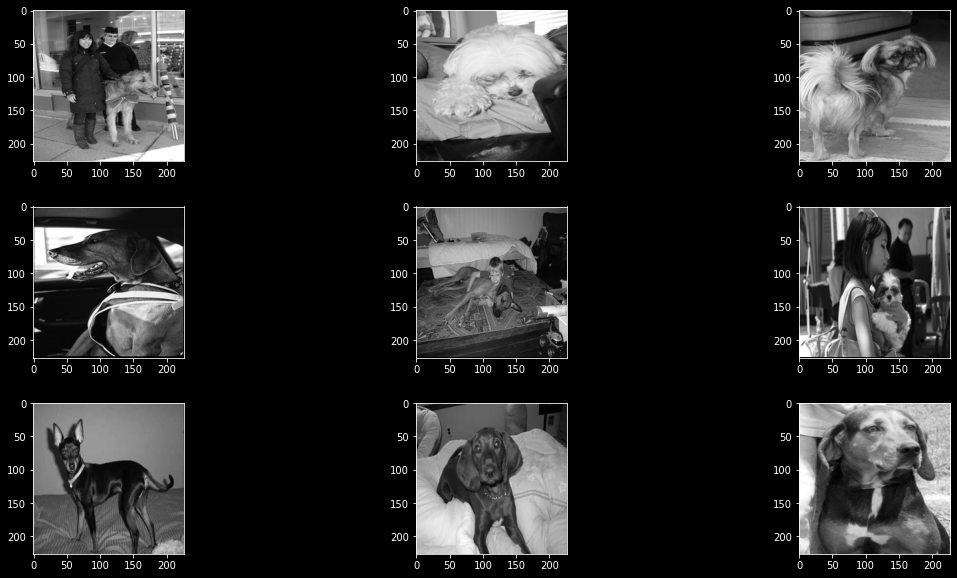

In [33]:
display_images(X_subset_gray, gray=True)

In [34]:
X_subset_gray = pd.DataFrame(X_subset_gray.reshape(X_subset_gray.shape[0], -1))

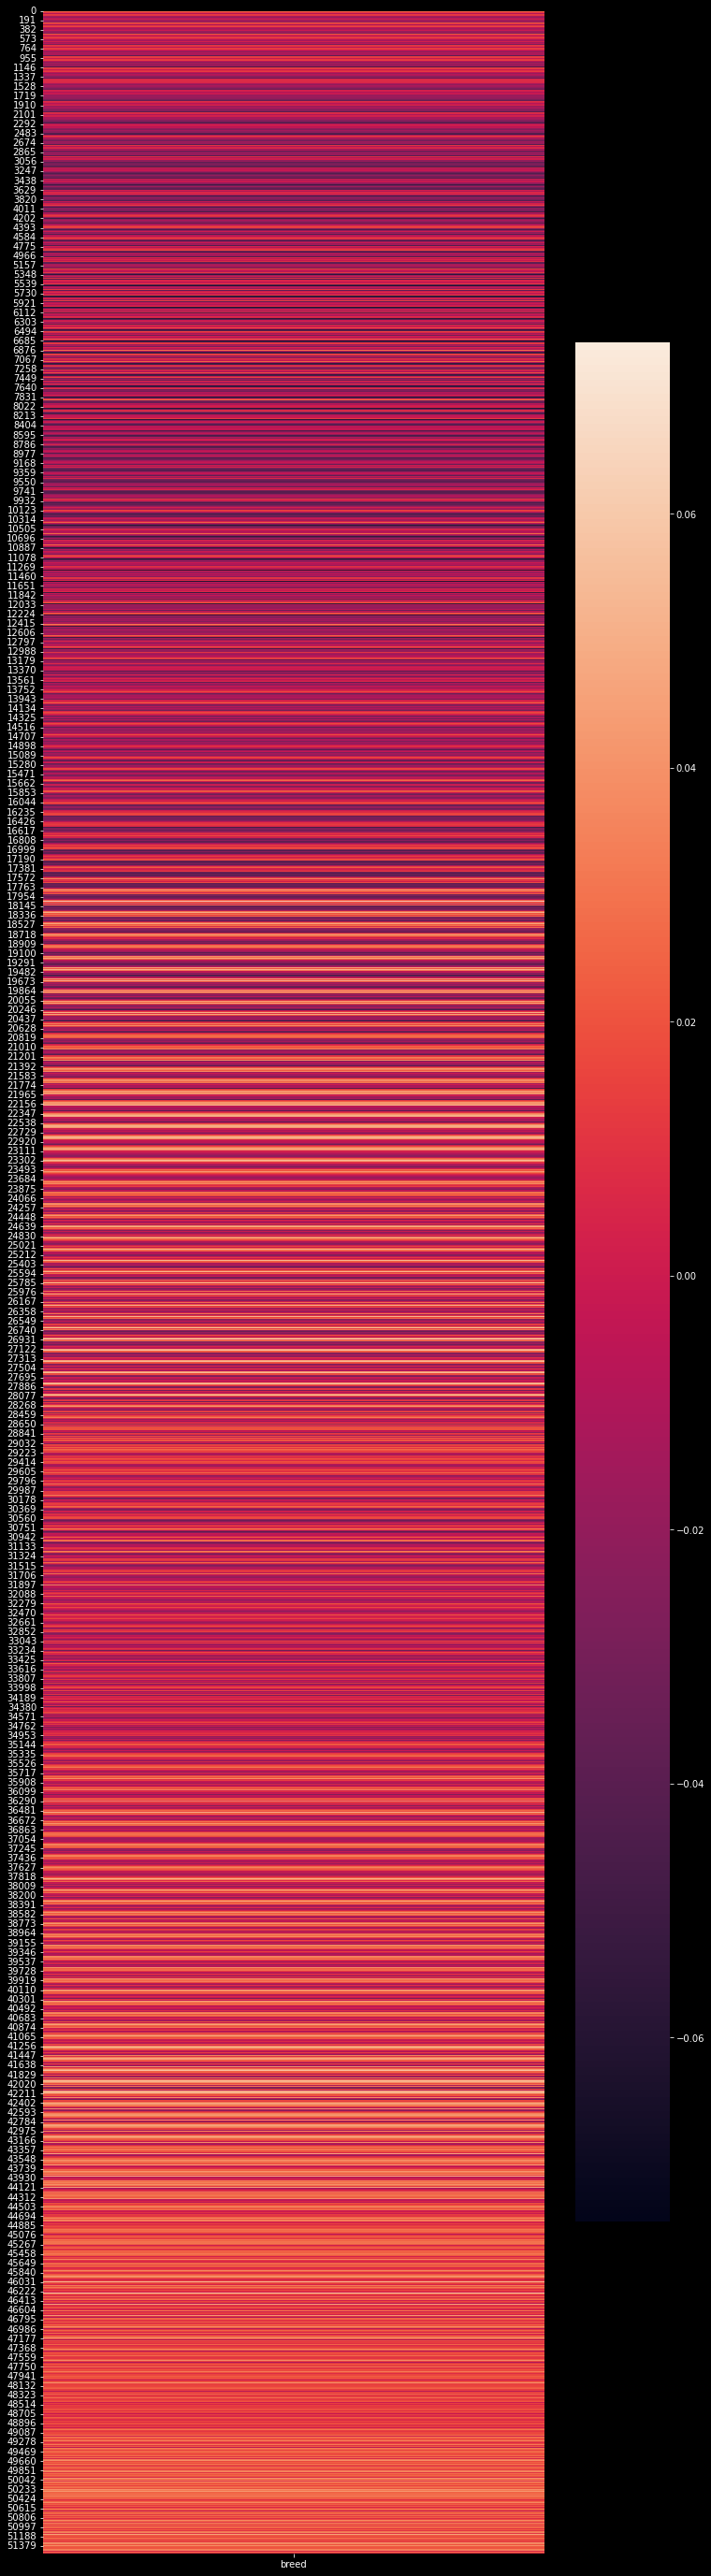

In [35]:
# Look at the useless features
c = pd.DataFrame({'breed': X_subset_gray.corrwith(y_train)})
plt.figure(figsize=(12,50))
sns.heatmap(c);

## Grayscale PCA

Text(0, 0.5, 'Cumulative explained variance')

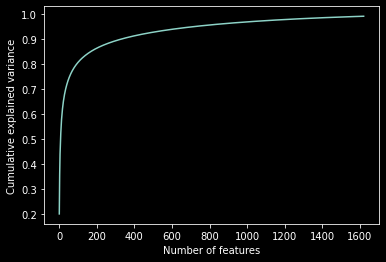

In [36]:
pca_gray = PCA(n_components=0.99)
pca_gray.fit(X_subset_gray, y_train)

plt.figure()
plt.plot(pca_gray.explained_variance_ratio_.cumsum())
plt.xlabel('Number of features')
plt.ylabel('Cumulative explained variance')

In [37]:
X_gray_reduced = pca_gray.fit_transform(X_subset_gray)
X_gray_recovered = pca_gray.inverse_transform(X_gray_reduced)

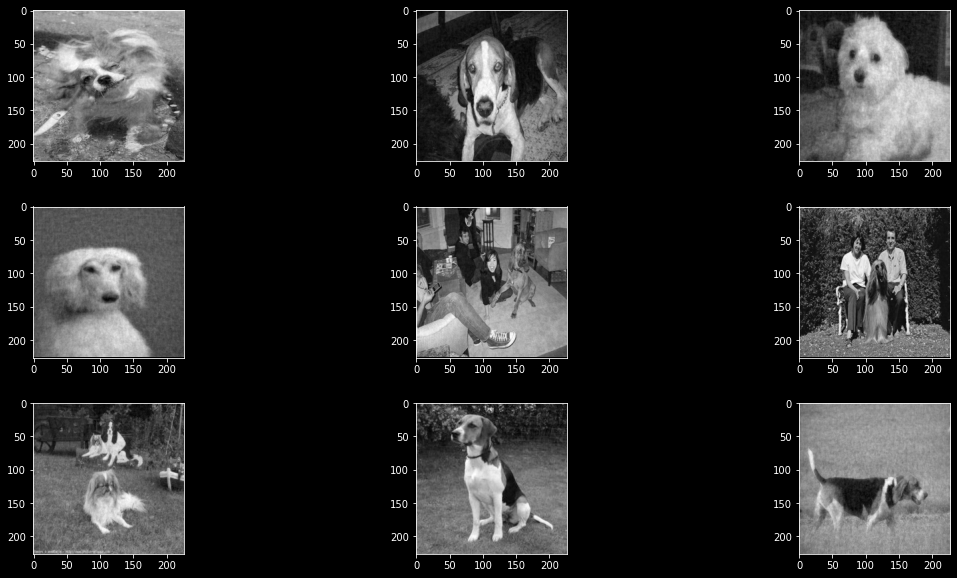

In [38]:
# Let's see how good the recovery is
display_images(X_gray_recovered.reshape(X_train.shape[0], 227, 227), gray=True);

In [39]:
# Find importances of each feature
rf_gray = RandomForestClassifier()
rf_gray.fit(X_subset_gray, y_train)
sorted(zip(rf_gray.feature_importances_, X_subset_gray.columns), reverse=True)

[(0.00016169657880209386, 29862),
 (0.00015875921826509094, 12613),
 (0.0001540250002265064, 30067),
 (0.00014992600316121927, 30551),
 (0.00014900096870669742, 23282),
 (0.0001472683073592171, 11914),
 (0.0001459934005889962, 28025),
 (0.00014598347355862003, 28465),
 (0.00014571611349188798, 28691),
 (0.00014429897300540805, 18530),
 (0.00014393424723012414, 27834),
 (0.00014314349733366173, 5574),
 (0.00014293581615087994, 40089),
 (0.0001427603765901779, 10571),
 (0.00014058433952341345, 30542),
 (0.00014030833657628606, 20574),
 (0.00013919310559684357, 11252),
 (0.00013731365039633736, 25071),
 (0.00013696783870663937, 20546),
 (0.00013645412284824478, 5801),
 (0.00013610016630953545, 33935),
 (0.0001340337443834022, 10528),
 (0.00013397566522881102, 29187),
 (0.00013391944894869506, 48367),
 (0.00013205513116263732, 27799),
 (0.00013200718533769548, 42530),
 (0.000131963734427673, 14851),
 (0.00013155383409321533, 20966),
 (0.00013071483423672946, 13300),
 (0.0001305677469362293

# Prepare the data 

In [40]:
def rgb_to_gray(X, reshape=True):
    """
    Converts to grayscale array
    TODO: write it better
    """
    if isinstance(X, pd.DataFrame):
      print("changing dataframe to grayscale")
      ims = X.values.reshape(X.shape[0], 227, 227, 3)
      gray_ims = np.array([cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) for im in ims])
      if reshape:
        return pd.DataFrame(gray_ims.reshape(X.shape[0], -1).reshape(X.shape[0], 227, 227, 1))
      return pd.DataFrame(gray_ims.reshape(X.shape[0], -1))

    elif isinstance(X, np.ndarray):
      print("changing ndarray to grayscale")
      ims = X.reshape(X.shape[0], 227, 227, 3)
      gray_ims = np.array([cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) for im in ims])
      if reshape:
          return gray_ims.reshape(X.shape[0], -1).reshape(X.shape[0], 227, 227, 1)
      return gray_ims.reshape(X.shape[0], -1)
    else:
      print("No changes")
      return X  



In [41]:
preprocessor_gray = Pipeline([
    ('grayscale', FunctionTransformer(rgb_to_gray)),
    ('pca', PCA(n_components=0.99)), # TODO: Look at IncrementalPCA, may need for full dataset
])

In [42]:
preprocessor_color = Pipeline([
    ('pca', PCA(n_components=0.99)), # TODO: Look at IncrementalPCA, may need for full dataset
])

# Short-list

In [43]:
def build_dog_network(input_shape=X_train_[0].shape, n_hidden_layers=5, n_neurons=100):
    """
    """
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=input_shape, name='input'))
    for i in range(n_hidden_layers):
        model.add(keras.layers.Dense(n_neurons, activation="relu", name=f'hidden_{i}'))
    model.add(keras.layers.Dense(1, name='output'))
    model.summary()
    model.compile(optimizer="Nadam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [44]:
def build_alexnet(is_gray=False):
    """
    """
    from keras.models import Sequential
    from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization
    if is_gray:
      in_shape = (227,227,1)
    else:
      in_shape = (227,227,3)

    model=Sequential()

    #1 conv layer
    model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=in_shape))

    #1 max pool layer
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

    model.add(BatchNormalization())

    #2 conv layer
    model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

    #2 max pool layer
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

    model.add(BatchNormalization())

    #3 conv layer
    model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

    #4 conv layer
    model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

    #5 conv layer
    model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

    #3 max pool layer
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

    model.add(BatchNormalization())


    model.add(Flatten())

    #1 dense layer
    model.add(Dense(4096,input_shape=in_shape,activation="relu"))

    model.add(Dropout(0.4))

    model.add(BatchNormalization())

    #2 dense layer
    model.add(Dense(4096,activation="relu"))

    model.add(Dropout(0.4))

    model.add(BatchNormalization())

    #3 dense layer
    model.add(Dense(1000,activation="relu"))

    model.add(Dropout(0.4))

    model.add(BatchNormalization())

    #output layer
    model.add(Dense(20,activation="softmax"))

    model.summary()
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

## Gray-scale

### Random Forest

In [ ]:
# TODO: issue with preprocessor
# rf_gray_pipeline = Pipeline([
#     ('preprocessor', preprocessor_gray),
#     ('classifier', RandomForestClassifier())
# ]).fit(X_train, y_train)

In [ ]:
# rf_gray_scores = cross_val_score(rf_gray_pipeline, X_train, y_train, scoring="accuracy")
# rf_gray_scores

### Extra Trees

In [ ]:
# TODO: Issue with preprocessor
# et_gray_pipeline = Pipeline([
#         ('preprocessor', preprocessor_gray),
#         ('classifier', ExtraTreesClassifier())
# ]).fit(X_train, y_train)

In [ ]:
# et_gray_scores = cross_val_score(et_gray_pipeline, X_train, y_train, scoring="accuracy")
# et_gray_scores

### Gray Neural Nets

#### Our Own Neural Net

In [ ]:
# nn_grey_clf = keras.wrappers.scikit_learn.KerasClassifier(build_dog_network, input_shape=X_train_.shape[1]//3, n_hidden_layers=5, n_neurons=100)

In [ ]:
# nn_grey = Pipeline([
#     ('grayscale', FunctionTransformer(rgb_to_gray)),
#     ('classifier', nn_grey_clf),
# ]).fit(X_train_, y_train_)

In [ ]:
# nn_cust_grey_scores = cross_val_score(nn_grey, X_train_, y_train_, scoring="accuracy")
# nn_cust_grey_scores

#### AlexNet for Grey Scale

In [45]:
alexnet_grey = keras.wrappers.scikit_learn.KerasClassifier(build_alexnet, is_gray=True)

C:\Users\matth\AppData\Local\Temp/ipykernel_21664/3699981227.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  alexnet_grey = keras.wrappers.scikit_learn.KerasClassifier(build_alexnet, is_gray=True)


In [46]:
alexnet_grey.fit( rgb_to_gray(X_train_), y_train_, epochs=100)

changing ndarray to grayscale
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        11712     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                          

KeyboardInterrupt: 

In [ ]:
val_pred_grey = alexnet_grey.predict(rgb_to_gray(X_val))
val_pred_grey.shape

In [ ]:
plt.figure(1, figsize=(19, 10))

for i in range(9):
    r = np.random.randint(0, X_val.shape[0], 1)
    
    plt.subplot(3, 3, i+1)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(X_val[r[0]])
    plt.title('Actual = {} ({}), \nPredicted = {} ({})'.format(y_val[r[0]], names[y_val[r[0]]], 
                                                               val_pred_grey[r[0]], names[val_pred_grey[r[0]]]))
    plt.xticks([]) , plt.yticks([])

plt.show()

In [ ]:
score_grey = sum(y_val == val_pred_grey) / X_val.shape[0]
score_grey

## Color

### Random Forest

In [ ]:
rf_color_pipeline = Pipeline([
    ('classifier', RandomForestClassifier())
]).fit(X_train, y_train)

In [ ]:
rf_color_scores = cross_val_score(rf_color_pipeline, X_train, y_train, scoring="accuracy")
rf_color_scores

### Extra Trees

In [ ]:
et_color_pipeline = Pipeline([
        ('classifier', ExtraTreesClassifier())
]).fit(X_train, y_train)

In [ ]:
et_color_scores = cross_val_score(et_color_pipeline, X_train, y_train, scoring="accuracy")
et_color_scores

### Color Neural Nets

#### Our Own Neural Net

In [ ]:
# color_nn = keras.wrappers.scikit_learn.KerasClassifier(build_dog_network, input_shape=(227,227,3), n_hidden_layers=5, n_neurons=100)

In [ ]:
# color_nn.fit(X_train_, y_train_, epochs=10)

In [ ]:
# nn_cust_color_scores = cross_val_score(color_nn, X_train_, y_train_, scoring="accuracy")
# nn_cust_color_scores

#### AlexNet for colored

In [48]:
alexnet_color = keras.wrappers.scikit_learn.KerasClassifier(build_alexnet)

C:\Users\matth\AppData\Local\Temp/ipykernel_21664/4264617295.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  alexnet_color = keras.wrappers.scikit_learn.KerasClassifier(build_alexnet)


In [50]:
alexnet_color.fit(X_train_, y_train_, epochs=100)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 batch_normalization_12 (Bat  (None, 27, 27, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                      

KeyboardInterrupt: 

In [ ]:
val_pred_color = alexnet_color.predict(X_val)
val_pred_color.shape

In [ ]:
plt.figure(1, figsize=(19, 10))

for i in range(9):
    r = np.random.randint(0, X_val.shape[0], 1)
    
    plt.subplot(3, 3, i+1)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(X_val[r[0]])
    plt.title('Actual = {} ({}), \nPredicted = {} ({})'.format(y_val[r[0]], names[y_val[r[0]]], 
                                                               val_pred_color[r[0]], names[val_pred_color[r[0]]]))
    plt.xticks([]) , plt.yticks([])

plt.show()

In [ ]:
score_color = sum(y_val == val_pred_color) / X_val.shape[0]
score_color

### Good Models

In [ ]:
et_color_pipeline.get_params().keys()

In [ ]:
# the AlexNet color is likely the better choice

# Fine-tune your models

In [ ]:
# Try fine tuning the extra trees
param_grid = [
    { 
      'classifier__n_estimators': [180, 200, 220],
      'classifier__max_depth': [10,12, 15], 
      'classifier__max_leaf_nodes': [10,12, 15], 
    }
]

search = GridSearchCV(et_color_pipeline, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1);
search.fit(X_train, y_train);

In [ ]:
models = zip(search.cv_results_['mean_test_score'], search.cv_results_['params'])
for mean_score, params in sorted(models, key=lambda x: x[0], reverse=True)[:10]:
    print(mean_score, params)

In [ ]:
search.best_params_

Scores not improving much from grid search...

# Present your solution 

In [ ]:
final_pred = alexnet_color.predict(X_test_)
final_score = sum(y_test_ == final_pred) / X_test_.shape[0]
final_score

In [ ]:
plt.figure(1, figsize=(19, 10))

for i in range(9):
    r = np.random.randint(0, X_test_.shape[0], 1)
    
    plt.subplot(3, 3, i+1)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(X_val[r[0]])
    plt.title('Actual = {} ({}), \nPredicted = {} ({})'.format(y_test_[r[0]], names[y_test_[r[0]]], 
                                                               final_pred[r[0]], names[final_pred[r[0]]]))
    plt.xticks([]) , plt.yticks([])

plt.show()



A few attempts at modifications to gridsearch were unable to yield better results than the defaults. We were unable to run sklearn models using grayscaled images (had a bug we didn't have time to track down)

Therefore, our best model was the AlexNet using color which had a <mark>%</mark> precision on the test set and had <mark>% evaluate!!</mark> accuracy. 
This model slightly outperformed the one that used grayscale images.

Our results were not great... Part of this is because we did not have enough memory to do lots of transformations. 
Ideally, we could add more transformations on the images (such as flipping them upside down, cropping, etc). Another issue is that there are a good chunk of not great images to begin with. Some images barely have a dog in them and some have multiple dogs. We also had to cut down the number of breeds we were doing (mostly due to memory constraints). We didn't check but the first 20 categories could have poorly distributed amounts of images, or the most difficult dogs to distinguish, (or outright the worst images). This could be part of the cause for our low scores. 

[see more here](https://docs.google.com/presentation/d/19PBfOdaeBKNb2NyIfJWTD0xQLSJ59Cuu5T2Bj3hKmw0/edit?usp=sharing)